<center>
<div>Machine Learning and Human Behavior - 236608 - Winter 2022-2023</div>
<h1>Workshop #1 - Binary Choice ⚖️</h1>
</center>

Mor Filo 313431264

Shani Goren 318643111

# Instructions and submission guidelines

* Clone this notebook and complete the exercise:
    * Aim for clear and concise solutions.
    * Indicate clearly with a text block the sections of your solutions.
    * Answer dry questions in text (markdown) blocks, and wet questions in code blocks.
* Submission guidelines:
    * Add a text block in the beginning of your notebook with your IDs.
    * When you're done, restart the notebook and make sure that everything runs smoothly (Runtime->"Restart and Run All")
    * Export your notebook as ipynb (File->Download->"Download .ipynb")
    * If you need to attach additional files to your submission (e.g images), add them to a zip file together with the notebook ipynb file.
    * Submit through the course website. Remember to list partner IDs when you submit.
* **Due date**: Monday 21/11/2022, 23:59
* For any questions regarding this workshop task, contact [Eden](mailto:edens@campus.technion.ac.il).


# Introduction


In the binary choice setting, users $u\in U$ make a binary decision of whether or not to consume items $x \in X$. Each item is represented by a vector $x\in\mathbb{R}^n$, and the outcome is represented using binary variable $y\in\left\{0,1\right\}$, such that $y=1$ when the item was consumed. 

Given a predicate such as $x\ge 0$, we denote its corresponding indicator function by $\mathbb{1}(x\ge 0)\in\{0,1\}$.

## Abstract population models 

For the implementation of behavioral models, we define the abstract classes which handle data generation and formatting. These are similar to the abstract classes defined in HW1.

As we will mostly use these classes through their public interface, there is no need to go through the implementation in detail.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import sklearn.metrics
import sklearn.linear_model
import sklearn.metrics

from tqdm.auto import tqdm

In [2]:
class DiscreteChoiceEnvironment:
    """
    Generic class for discrete-choice dataset generation
    """
    n_features = 8
    observations_per_user = 10
    train_user_proportion = 0.6

    def _generate_user_attributes(self, n_users):
        """
        Generate latent parameters for users.

        Parameters
        ----------
        n_users : int

        Output
        ------
        users : ndarray of shape (n_users, n_features)
        """
        return np.random.normal(
            loc=1,
            scale=0.1,
            size=(
                n_users,
                self.n_features,
            ),
        )
    
    def _generate_item_attributes(self, n_users):
        """
        Generate latent parameters for items.

        Parameters
        ----------
        n_users : int

        Output
        ------
        items : ndarray of shape
                (n_users, observations_per_user, n_features)
        """
        return np.random.normal(
            size=(
                n_users,
                self.observations_per_user,
                self.n_features,
            ),
        )

    def _choice(self, users, items):
        """
        Discrete choice function
        
        Parameters
        ----------
        users : ndarray of shape (n_users, n_features)
        items : ndarray of shape
                (n_users, observations_per_user, n_features)

        Output
        ------
        choice : Dict[str -> ndarray of shape(n_users, observations_per_user)]
        """
        raise NotImplementedError
    
    def _generate_choice_dataset(self, n_users):
        """
        Generate choice dataset, formatted as pandas dataframe.
        """
        users = self._generate_user_attributes(n_users)
        items = self._generate_item_attributes(n_users)
        choice_dct = self._choice(users, items)
        rows = []
        for i in range(n_users):
            for j in range(self.observations_per_user):
                dct = {}
                dct['user_id'] = f'{i}'
                for k in range(self.n_features):
                        dct[f'x_{k}'] = items[i,j,k]
                for choice_type, choice_matrix in choice_dct.items():
                    dct[choice_type] = choice_matrix[i,j]
                rows.append(dct)
        df = pd.DataFrame(rows)
        return df
    
    def generate_train_eval_datasets(self, n_users):
        n_train_users = int(n_users*self.train_user_proportion)
        n_test_users = n_users - n_train_users
        return (
            self._generate_choice_dataset(n_train_users),
            self._generate_choice_dataset(n_test_users),
        )

    def get_feature_columns(self):
        return [
            f'x_{k}'
            for k in range(self.n_features)
        ]


class InnerProductTrueValueEnvironment(DiscreteChoiceEnvironment):
    @staticmethod
    def _true_value(users, items):
        # true_value is an inner product u@x.
        # Calculate using np.einsum, where:
        # * i: user index
        # * j: observation (item) index
        # * k: feature
        true_value = np.einsum('ik,ijk->ij', users, items)
        return true_value


# Task \#1: Prediction with stated and revealed preferences


## Introduction

In our first task, we will investigate the relation between predictive performance, and the type of feedback obtained from users.

We assume that consumption decisions are made according to the a random utility model. Each user is represented by a vector $u\in\mathbb{R}^d$, and each item is represented by a vector $x\in\mathbb{R}^d$. The true utility experienced by user $u$ from consuming item $x$ is assumed to be the inner product $v_u(x)=u^Tx$.

We distinguish between three types of feedback:

* **Rational preference**: When user $u$ is queried in an ideal environment, they consume the item if its utility is larger than zero. Their rational choice is to consume if the utility is larger than zero, hence $y_\mathrm{rational} = \mathbb{1}(v_u(x) \ge 0)$.

* **Stated preference**: When user $u$ is questioned explicitly about item $x$ (e.g in a survey), they tend to under-estimate the value of the item. Therefore, their stated consumption choice is given by $y_\mathrm{stated} = \mathbb{1}(v_u(x)-b \ge 0)$, where $b\ge 0$ is a fixed and latent bias term.

* **Revealed preference**: When $u$ is presented with item item $x$, they reply according to a noisy evaluation $y_\mathrm{revealed} = \mathbb{1}(v_u(x)+\varepsilon \ge 0)$, where $\varepsilon\sim N(0,\sigma)$.



## Exercise 1.1: Simulating user behavior

The `NoisyBinaryChoiceEnvironment` class will be used for generating the datasets. It provides a simple interface which will be useful for simulation.



In [3]:
class NoisyBinaryChoiceEnvironment(InnerProductTrueValueEnvironment):
    """
    Dataset generator for binary choice with decision noise
    """
    def __init__(self, noise_scale, bias=1):
        self.noise_scale = noise_scale
        self.bias = bias

    def _choice(self, users, items):
        true_value = self._true_value(users, items)
        decision_noise = np.random.normal(
            size=true_value.shape,
            scale=self.noise_scale,
        )
        stated_value = true_value-self.bias
        perceived_value = true_value + decision_noise
        return {
            'true_value': true_value,
            'rational_choice': true_value >= 0,
            'stated_choice': stated_value >= 0,
            'revealed_choice': perceived_value >= 0,
        }



As an example, here we instantiate an environment with noise magnitude $\sigma=2$, generate training and evaluation datasets with 1000 users. Note that the training and evaluation datasets are pandas DataFrames:

In [6]:
example_noisy_choice_env = NoisyBinaryChoiceEnvironment(noise_scale=2)
example_train_df, example_eval_df = example_noisy_choice_env.generate_train_eval_datasets(n_users=1000)
example_train_df.head()

,user_id,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,true_value,rational_choice,stated_choice,revealed_choice
0,0,-0.964024,-1.224440,-1.123410,-0.454605,0.421541,1.268544,-0.600585,-2.006168,-4.880445,False,False,False
1,0,1.331779,0.569552,0.659752,-0.098284,-1.224462,0.130099,-0.950973,0.620800,1.106090,True,True,True
2,0,-0.268215,-0.517285,-0.929617,0.627685,0.030305,0.074915,0.587640,0.049163,-0.390478,False,False,False
3,0,0.170930,1.857949,-0.166576,-2.142850,1.789045,-0.195456,0.548195,0.927132,3.117014,True,True,True
4,0,0.343499,-0.461447,2.472662,1.441614,-0.932927,-0.050404,0.498292,-0.142311,3.170443,True,True,True


We can also extract features and train models using sklearn. Here we use the training set to fit a Logistic Regression model, and predict on the evaluation set:

In [7]:
example_model = sklearn.linear_model.LogisticRegression().fit(
    X=example_train_df[example_noisy_choice_env.get_feature_columns()],
    y=example_train_df['revealed_choice'],
)
example_model.predict(
    X=example_eval_df[example_noisy_choice_env.get_feature_columns()],
)

array([False, False,  True, ...,  True, False, False])

**Warm-up question**:

In the `example_eval_df` dataset:
* What is the proportion of positive consumption choices under the `rational_choice` criteria ($y_\mathrm{rational}=1$)?
* What is the proportion of positive consumption choices under the `stated_choice` criteria ($y_\mathrm{stated}=1$)?
* What is the proportion of positive consumption choices under the `revealed_choice` criteria ($y_\mathrm{revealed}=1$)?

🔵 **Answer**:

In [ ]:
## YOUR SOLUTION
num_entries = example_train_df['rational_choice'].count()
rational = example_train_df['rational_choice'].sum()
print(f"positive consumption choices under the rational_choice criteria: {rational/num_entries}")
stated = example_train_df['stated_choice'].sum()
print(f"positive consumption choices under the stated_choice criteria: {stated/num_entries}")
revealed = example_train_df['revealed_choice'].sum()
print(f"positive consumption choices under the revealed_choice criteria: {revealed/num_entries}")

positive consumption choices under the rational_choice criteria: 0.498
positive consumption choices under the stated_choice criteria: 0.3591666666666667
positive consumption choices under the revealed_choice criteria: 0.5028333333333334


## Exercise 1.2: Comparison graph

Plot three line graphs (on the same figure) representing the accuracy of a linear regression model, for variable $\sigma$. Plot one line graph for *stated preferences*, and another line for *revealed preferences*.  

For each decision noise magnitude $\sigma$ in the range $\sigma\in[0.1,20]$:
* Instantiate a `NoisyBinaryChoiceEnvironment` environment with the given magnitude, and generate training/evaluation datasets with `n_users=20`. 
* Use the training set to train three Logistic Regression models, using $y_\mathrm{rational}$, $y_\mathrm{stated}$ and $y_\mathrm{revealed}$ as training labels.
* Evaluate model accuracy on predicting $y_\mathrm{revealed}$ of the evaluation set.

To reduce randomization noise, repeat the experiment 20 times for each $\sigma$, and average the results.

Hints:
* Code should be simple and concise. Don't reinvent the wheel!
* Given an environment `env` and a generated dataset `train_df`:
  * `train_df['rational_choice']` is the user's rational choice $y_\mathrm{rational}$. Similarly for $y_\mathrm{stated}$, $y_\mathrm{revealed}$.
  * `train_df[env.get_feature_columns()]` extracts the feature columns from the DataFrame.
* Use `sklearn.linear.LogisticRegression` as the prediction model:
  * Note that pandas DataFrames are valid datatypes for sklearn's `X` and `y` arguments.
  * Given a trained Logistic Regression model `m`, the command `m.score(X,y)` returns the mean accuracy on the given test data and labels.
* Figures should be clear and organized. Make sure that title, axis labels, and legend are added and clearly labeled.

🔵 **Answer**:

In [10]:
noise_scale_vec = np.linspace(0.1,20,10)

In [20]:
noise_scale_vec = np.linspace(0.1,20,10)
task1_n_repetitions = 20
task1_n_users = 20

## YOUR SOLUTION
avg_accuracy_rational= np.zeros(noise_scale_vec.shape[0])
avg_accuracy_stated = np.zeros(noise_scale_vec.shape[0])
avg_accuracy_revealed = np.zeros(noise_scale_vec.shape[0])

for i, noise in enumerate(noise_scale_vec):
    for rep in range(task1_n_repetitions):
        noisy_choice_env = NoisyBinaryChoiceEnvironment(noise_scale=noise)
        train_df, eval_df = noisy_choice_env.generate_train_eval_datasets(n_users=task1_n_users)
        feature_columns = noisy_choice_env.get_feature_columns()
        x_train = train_df[feature_columns]
        x_test = eval_df[feature_columns]
        y_test = eval_df['revealed_choice']

        y_train_rational = train_df['rational_choice']
        model = sklearn.linear_model.LogisticRegression().fit(
            X=x_train,
            y=y_train_rational,
        )
        avg_accuracy_rational[i] += model.score(x_test, y_test)

        y_train_stated = train_df['stated_choice']
        model = sklearn.linear_model.LogisticRegression().fit(
            X=x_train,
            y=y_train_stated,
        )
        avg_accuracy_stated[i] += model.score(x_test, y_test)

        y_train_revealed = train_df['revealed_choice']
        model = sklearn.linear_model.LogisticRegression().fit(
            X=x_train,
            y=y_train_revealed,
        )
        avg_accuracy_revealed[i] += model.score(x_test, y_test)


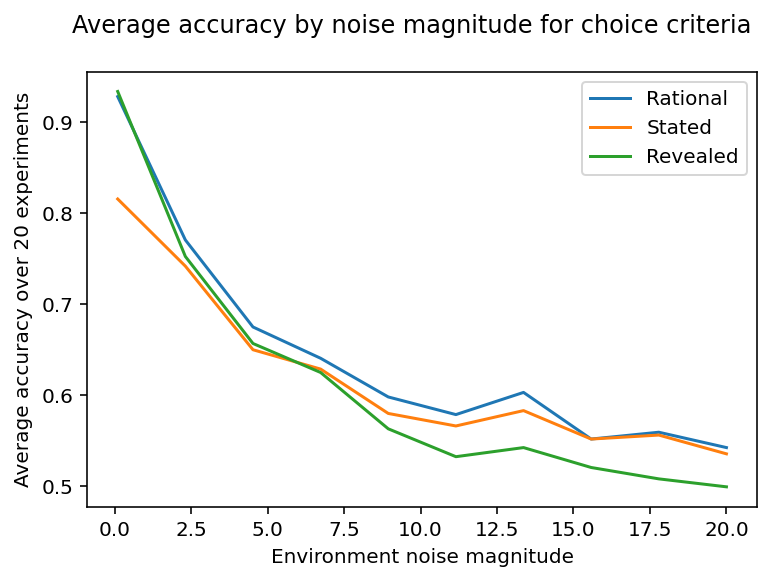

In [21]:
avg_accuracy_rational = avg_accuracy_rational/task1_n_repetitions
avg_accuracy_stated = avg_accuracy_stated/task1_n_repetitions
avg_accuracy_revealed = avg_accuracy_revealed/task1_n_repetitions

fig, ax = plt.subplots()
ax.plot(noise_scale_vec, avg_accuracy_rational, label='Rational')
ax.plot(noise_scale_vec, avg_accuracy_stated, label='Stated')
ax.plot(noise_scale_vec, avg_accuracy_revealed, label='Revealed')
fig.suptitle('Average accuracy by noise magnitude for choice criteria')
ax.set_xlabel('Environment noise magnitude')
ax.set_ylabel(f'Average accuracy over {task1_n_repetitions} experiments') # , rotation='horizontal') # There are many parameters - we should explore the documantation to find what we seek
ax.legend();

Explain the results in detail. In your answer, relate to:
* Overall trends: 
  * Are the lines increasing/decreasing/constant as a function of $\sigma$? Why?
* Relation between the lines: 
  * Assuming that $y_\mathrm{rational}$ can't be measured in practice - Which of the other methods is better when $\sigma\to 0$? which method is better when $\sigma\to \infty$? 
  * If lines cross each other, when and why do they cross? 
  * If lines coincide, when and why do they coincide?
* Range of values: 
  * What is the range of accuracy values obtained? 
  * How do they relate to upper/lower bounds of predictive performance?



🔵 **Answer**:

**Overall trends:**

The lines are decreasing as a function of $\sigma$ - as we increase $\sigma$, the revealed preferences which we want to predict have more noise added to them, which makes it harder for a linear regression to predict. 

**Relation between the lines:**

When $\sigma$ is close to 0, rational and revealed choice are very close, and the more $\sigma$ is increased they become further from each other, since rational choice doesn't take into consideration any added element to the true value. On the other hand, stated and revealed start rather far from each other, but as $\sigma$ approaches a noise magnitude of about 7, they get close because the fixed bias term simulates the added noise to the system. The fixed bias is 1, so after the mentioned point, the bias is not enough to simulate the noise, until a point where the added is so insignificant, almost like not subtracting from the true value in the first place, similiarly to the rational choice. For this reason, the rational and stated choice are very close as $\sigma$ has a very high value. 

As we have mentioned, when $\sigma$ is close to 0, the rational and revealed choice are very close. Therefore, we can use the revealed choice to as a proxy for measuring the rational choice.
When $\sigma$ values are very high, the bias becomes insignificant compared to the noise effect, and therefore the stated preference can be used as a proxy. 

Surprisingly (to us), training the model on the revealed choice resulted with the worst prediction accuracy of revealed choice itself when $\sigma>0$. This result emphasized to us the effect of adding noise to the train data making it hard for the linear regressor to fit a line to noisy data points (especially of less than 20 data points). 

**Range of values:**

The range of accuracy values obtained is 50%-~95%.
We can see that when we add a signficant amount of noise to the system, the models' ability to predict the users' revealed choice is not much better than a random predictor (with 50% accuracy). 

  * How do they relate to upper/lower bounds of predictive performance?

## Exercise 1.3: Evaluating Welfare

Plot a similar graph for the welfare metric you created in HW1:

$$
\mathrm{welfare}(f, S)=\frac{1}{|S|}\sum_{ (u,x) \in S } f(x) v_u(x)
$$

🔵 **Answer**:

In [22]:
## YOUR SOLUTION
def welfare(f, eval_df, feature_columns, value_column):
    """
    Calculate the welfare for the given evaluation set
    
    Parameters
    ----------
    f : prediction function from pandas dataframe to {0,1}
    eval_df : pandas DataFrame, as returned by env.generate_train_eval_datasets
    feature_columns : names of feature columns (e.g `env.get_feature_columns()`)
    value_column : name of value column (e.g `true_value`)

    Output
    ------
    welfare : float
    """
    ## YOUR SOLUTION
    x = eval_df[feature_columns]
    y = f(x).astype(float)
    v = eval_df[value_column].astype(float)
    welfare = np.sum(v@y)/(eval_df.shape[0])
    return welfare

In [23]:
noise_scale_vec = np.linspace(0.1,20,10)
task1_n_repetitions = 20
task1_n_users = 20

## YOUR SOLUTION
avg_welfare_rational= np.zeros(noise_scale_vec.shape[0])
avg_welfare_stated = np.zeros(noise_scale_vec.shape[0])
avg_welfare_revealed = np.zeros(noise_scale_vec.shape[0])

for i, noise in enumerate(noise_scale_vec):
    for rep in range(task1_n_repetitions):
        noisy_choice_env = NoisyBinaryChoiceEnvironment(noise_scale=noise)
        train_df, eval_df = noisy_choice_env.generate_train_eval_datasets(n_users=task1_n_users)
        feature_columns = noisy_choice_env.get_feature_columns()
        x_train = train_df[feature_columns]
        x_test = eval_df[feature_columns]

        y_train_rational = train_df['rational_choice']
        model = sklearn.linear_model.LogisticRegression().fit(
            X=x_train,
            y=y_train_rational,
        )
        avg_welfare_rational[i] += welfare(model.predict, eval_df, feature_columns, 'true_value')

        y_train_stated = train_df['stated_choice']
        model = sklearn.linear_model.LogisticRegression().fit(
            X=x_train,
            y=y_train_stated,
        )
        avg_welfare_stated[i] += welfare(model.predict, eval_df, feature_columns, 'true_value')

        y_train_revealed = train_df['revealed_choice']
        model = sklearn.linear_model.LogisticRegression().fit(
            X=x_train,
            y=y_train_revealed,
        )
        avg_welfare_revealed[i] += welfare(model.predict, eval_df, feature_columns, 'true_value')


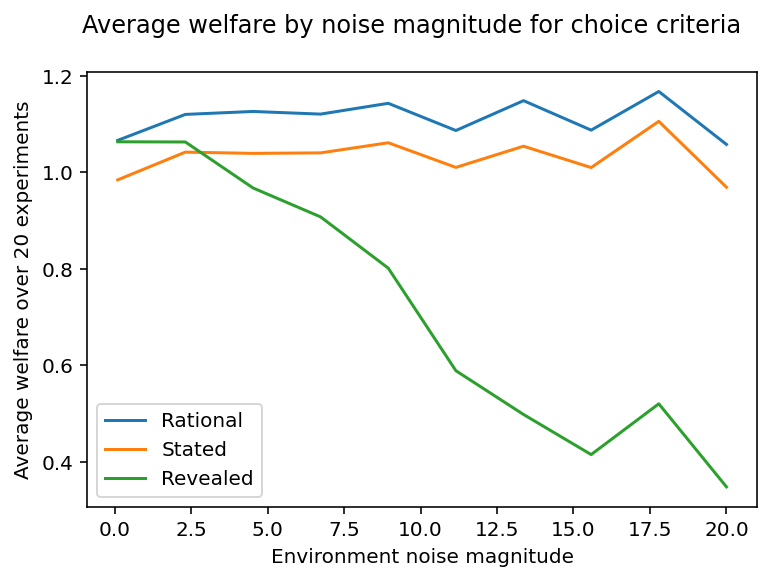

In [24]:
avg_welfare_rational = avg_welfare_rational/task1_n_repetitions
avg_welfare_stated = avg_welfare_stated/task1_n_repetitions
avg_welfare_revealed = avg_welfare_revealed/task1_n_repetitions

fig, ax = plt.subplots()
ax.plot(noise_scale_vec, avg_welfare_rational, label='Rational')
ax.plot(noise_scale_vec, avg_welfare_stated, label='Stated')
ax.plot(noise_scale_vec, avg_welfare_revealed, label='Revealed')
fig.suptitle('Average welfare by noise magnitude for choice criteria')
ax.set_xlabel('Environment noise magnitude')
ax.set_ylabel(f'Average welfare over {task1_n_repetitions} experiments') # , rotation='horizontal') # There are many parameters - we should explore the documantation to find what we seek
ax.legend();

Explain your results:

🔵 **Answer**:

The noise factor is not taken into consideration when calculating the value of the rational and stated choice, and therefore in an ideal environment we would expect the welfare to stay fixed over all noise magnitudes. We attribute the fluctuations of the rational and stated choice graphs to the randomness of the optimization process when fitting a regressor to the train data. We noticed that the rational choice's averge welfare is always the highest across all experiments. Further, the welfare of rational is always bigger than stated by a fixed amount, which corresponds to the bias term - which demonstates the users' underestimation of items' values, resulting in "not buy" decisions. 

When observing the effect of noise on the revealed choice welfare, the more noise is added to the system, the lower the welfare gets. An explanation we found for this phenomenon can be that the revealed choice prediction accuracy gets worse as more noise is introduced, and effect on the welfare will be that, for example: low or negative true value items might be predicted as "buy" and therefore added to the welfare, while positivae and high true value items might be predicted as "not buy" and not added to the welfare. 

## Exercise 1.4: Welfare counter-example

**Assuming we use a linear classifer** (i.e. $y = \mathrm{sign}(w^Tx + b)$)

Find a dataset for which the classifier which yields the best accuracy, does not promote optimal welfare. Explain your answer.

In your answer, you should provide:
* Items and features
* Utility function (utility doen't have to be linear)
* Present a classifier, and explain why it's optimal in terms of accuracy.
* Present another classifier which may have worse accuracy but better welfare.

Note: you can sketch a 1D/2D dataset using Power-Point (taking a screenshot), or through this website: https://app.diagrams.net/. Describe the solution in words below. 

Attach the diagram inside a zip file together with your notebook when you submit your solution.

🔵 **Answer**:

Our dataset contains items with one feature, and the data points marked with '+' for buying the product (choice=true).
Utility function: constant 100 for all users and items.
A linear classifier will classify all points right to it as choice=1 (+), and left choice=0 (-).
The orange classifier predicts that only one user chooses the item, and it's optimal in accuracy - 75%, and the welfare is 100. 
The blue classifier predicts that all the users choose the item, and has accuracy of 50%, while the welfare will be 400. 

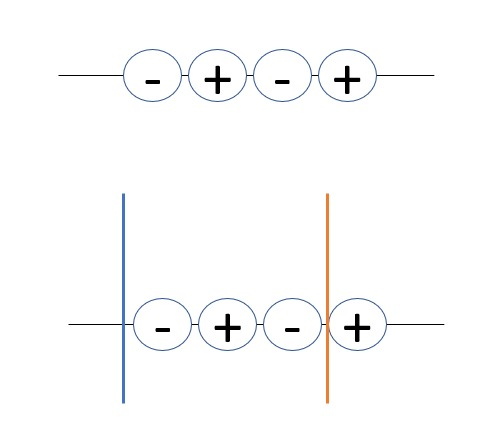

## Exercise 1.5: Exploratory Analysis (Open-Ended)


Looking at both measures (accuracy and welfare), try to vary the parameters of the experiment (\#users, \#items, \#features, etc.) in ways that show interesting trends. Explain your results in detail and support your claims.

🔵 **Answer**:

Due to the poor performance of revealed choice prediction accuracy in a noisy environment with only 20 users, our hypothesis is that adding more users to the environment might help us mitigate the noise effect.

First, we will conduct the same expirament as before (effect of noise on the acuraccy for fixed number of users and the three choice criteias) for 100,500,1000 users.

The reason we suspect that more data will lead to better performance on the revealed choice, is that adding more data taken from the same noisy distribution can "cancel" the effect of the noise. The idea is that the more data we sample from a distribution with a given variance and expectation, the 
closer we can get to the expectation.

In [25]:
## YOUR SOLUTION
noise_scale_vec = np.linspace(0.1,20,10)
task1_n_repetitions = 20
task1_n_users = 100

## YOUR SOLUTION
avg_accuracy_rational_100 = np.zeros(noise_scale_vec.shape[0])
avg_accuracy_stated_100 = np.zeros(noise_scale_vec.shape[0])
avg_accuracy_revealed_100 = np.zeros(noise_scale_vec.shape[0])

for i, noise in enumerate(noise_scale_vec):
    for rep in range(task1_n_repetitions):
        noisy_choice_env = NoisyBinaryChoiceEnvironment(noise_scale=noise)
        train_df, eval_df = noisy_choice_env.generate_train_eval_datasets(n_users=task1_n_users)
        feature_columns = noisy_choice_env.get_feature_columns()
        x_train = train_df[feature_columns]
        x_test = eval_df[feature_columns]
        y_test = eval_df['revealed_choice']

        y_train_rational = train_df['rational_choice']
        model = sklearn.linear_model.LogisticRegression().fit(
            X=x_train,
            y=y_train_rational,
        )
        avg_accuracy_rational_100[i] += model.score(x_test, y_test)

        y_train_stated = train_df['stated_choice']
        model = sklearn.linear_model.LogisticRegression().fit(
            X=x_train,
            y=y_train_stated,
        )
        avg_accuracy_stated_100[i] += model.score(x_test, y_test)

        y_train_revealed = train_df['revealed_choice']
        model = sklearn.linear_model.LogisticRegression().fit(
            X=x_train,
            y=y_train_revealed,
        )
        avg_accuracy_revealed_100[i] += model.score(x_test, y_test)

avg_accuracy_rational_100 = avg_accuracy_rational_100/task1_n_repetitions
avg_accuracy_stated_100 = avg_accuracy_stated_100/task1_n_repetitions
avg_accuracy_revealed_100 = avg_accuracy_revealed_100/task1_n_repetitions

In [26]:
## YOUR SOLUTION
noise_scale_vec = np.linspace(0.1,20,10)
task1_n_repetitions = 20
task1_n_users = 500

## YOUR SOLUTION
avg_accuracy_rational_500 = np.zeros(noise_scale_vec.shape[0])
avg_accuracy_stated_500 = np.zeros(noise_scale_vec.shape[0])
avg_accuracy_revealed_500 = np.zeros(noise_scale_vec.shape[0])

for i, noise in enumerate(noise_scale_vec):
    for rep in range(task1_n_repetitions):
        noisy_choice_env = NoisyBinaryChoiceEnvironment(noise_scale=noise)
        train_df, eval_df = noisy_choice_env.generate_train_eval_datasets(n_users=task1_n_users)
        feature_columns = noisy_choice_env.get_feature_columns()
        x_train = train_df[feature_columns]
        x_test = eval_df[feature_columns]
        y_test = eval_df['revealed_choice']

        y_train_rational = train_df['rational_choice']
        model = sklearn.linear_model.LogisticRegression().fit(
            X=x_train,
            y=y_train_rational,
        )
        avg_accuracy_rational_500[i] += model.score(x_test, y_test)

        y_train_stated = train_df['stated_choice']
        model = sklearn.linear_model.LogisticRegression().fit(
            X=x_train,
            y=y_train_stated,
        )
        avg_accuracy_stated_500[i] += model.score(x_test, y_test)

        y_train_revealed = train_df['revealed_choice']
        model = sklearn.linear_model.LogisticRegression().fit(
            X=x_train,
            y=y_train_revealed,
        )
        avg_accuracy_revealed_500[i] += model.score(x_test, y_test)

avg_accuracy_rational_500 = avg_accuracy_rational_500/task1_n_repetitions
avg_accuracy_stated_500 = avg_accuracy_stated_500/task1_n_repetitions
avg_accuracy_revealed_500 = avg_accuracy_revealed_500/task1_n_repetitions

In [27]:
## YOUR SOLUTION
noise_scale_vec = np.linspace(0.1,20,10)
task1_n_repetitions = 20
task1_n_users = 1000

## YOUR SOLUTION
avg_accuracy_rational_1000 = np.zeros(noise_scale_vec.shape[0])
avg_accuracy_stated_1000 = np.zeros(noise_scale_vec.shape[0])
avg_accuracy_revealed_1000 = np.zeros(noise_scale_vec.shape[0])

for i, noise in enumerate(noise_scale_vec):
    for rep in range(task1_n_repetitions):
        noisy_choice_env = NoisyBinaryChoiceEnvironment(noise_scale=noise)
        train_df, eval_df = noisy_choice_env.generate_train_eval_datasets(n_users=task1_n_users)
        feature_columns = noisy_choice_env.get_feature_columns()
        x_train = train_df[feature_columns]
        x_test = eval_df[feature_columns]
        y_test = eval_df['revealed_choice']

        y_train_rational = train_df['rational_choice']
        model = sklearn.linear_model.LogisticRegression().fit(
            X=x_train,
            y=y_train_rational,
        )
        avg_accuracy_rational_1000[i] += model.score(x_test, y_test)

        y_train_stated = train_df['stated_choice']
        model = sklearn.linear_model.LogisticRegression().fit(
            X=x_train,
            y=y_train_stated,
        )
        avg_accuracy_stated_1000[i] += model.score(x_test, y_test)

        y_train_revealed = train_df['revealed_choice']
        model = sklearn.linear_model.LogisticRegression().fit(
            X=x_train,
            y=y_train_revealed,
        )
        avg_accuracy_revealed_1000[i] += model.score(x_test, y_test)

avg_accuracy_rational_1000 = avg_accuracy_rational_1000/task1_n_repetitions
avg_accuracy_stated_1000 = avg_accuracy_stated_1000/task1_n_repetitions
avg_accuracy_revealed_1000 = avg_accuracy_revealed_1000/task1_n_repetitions

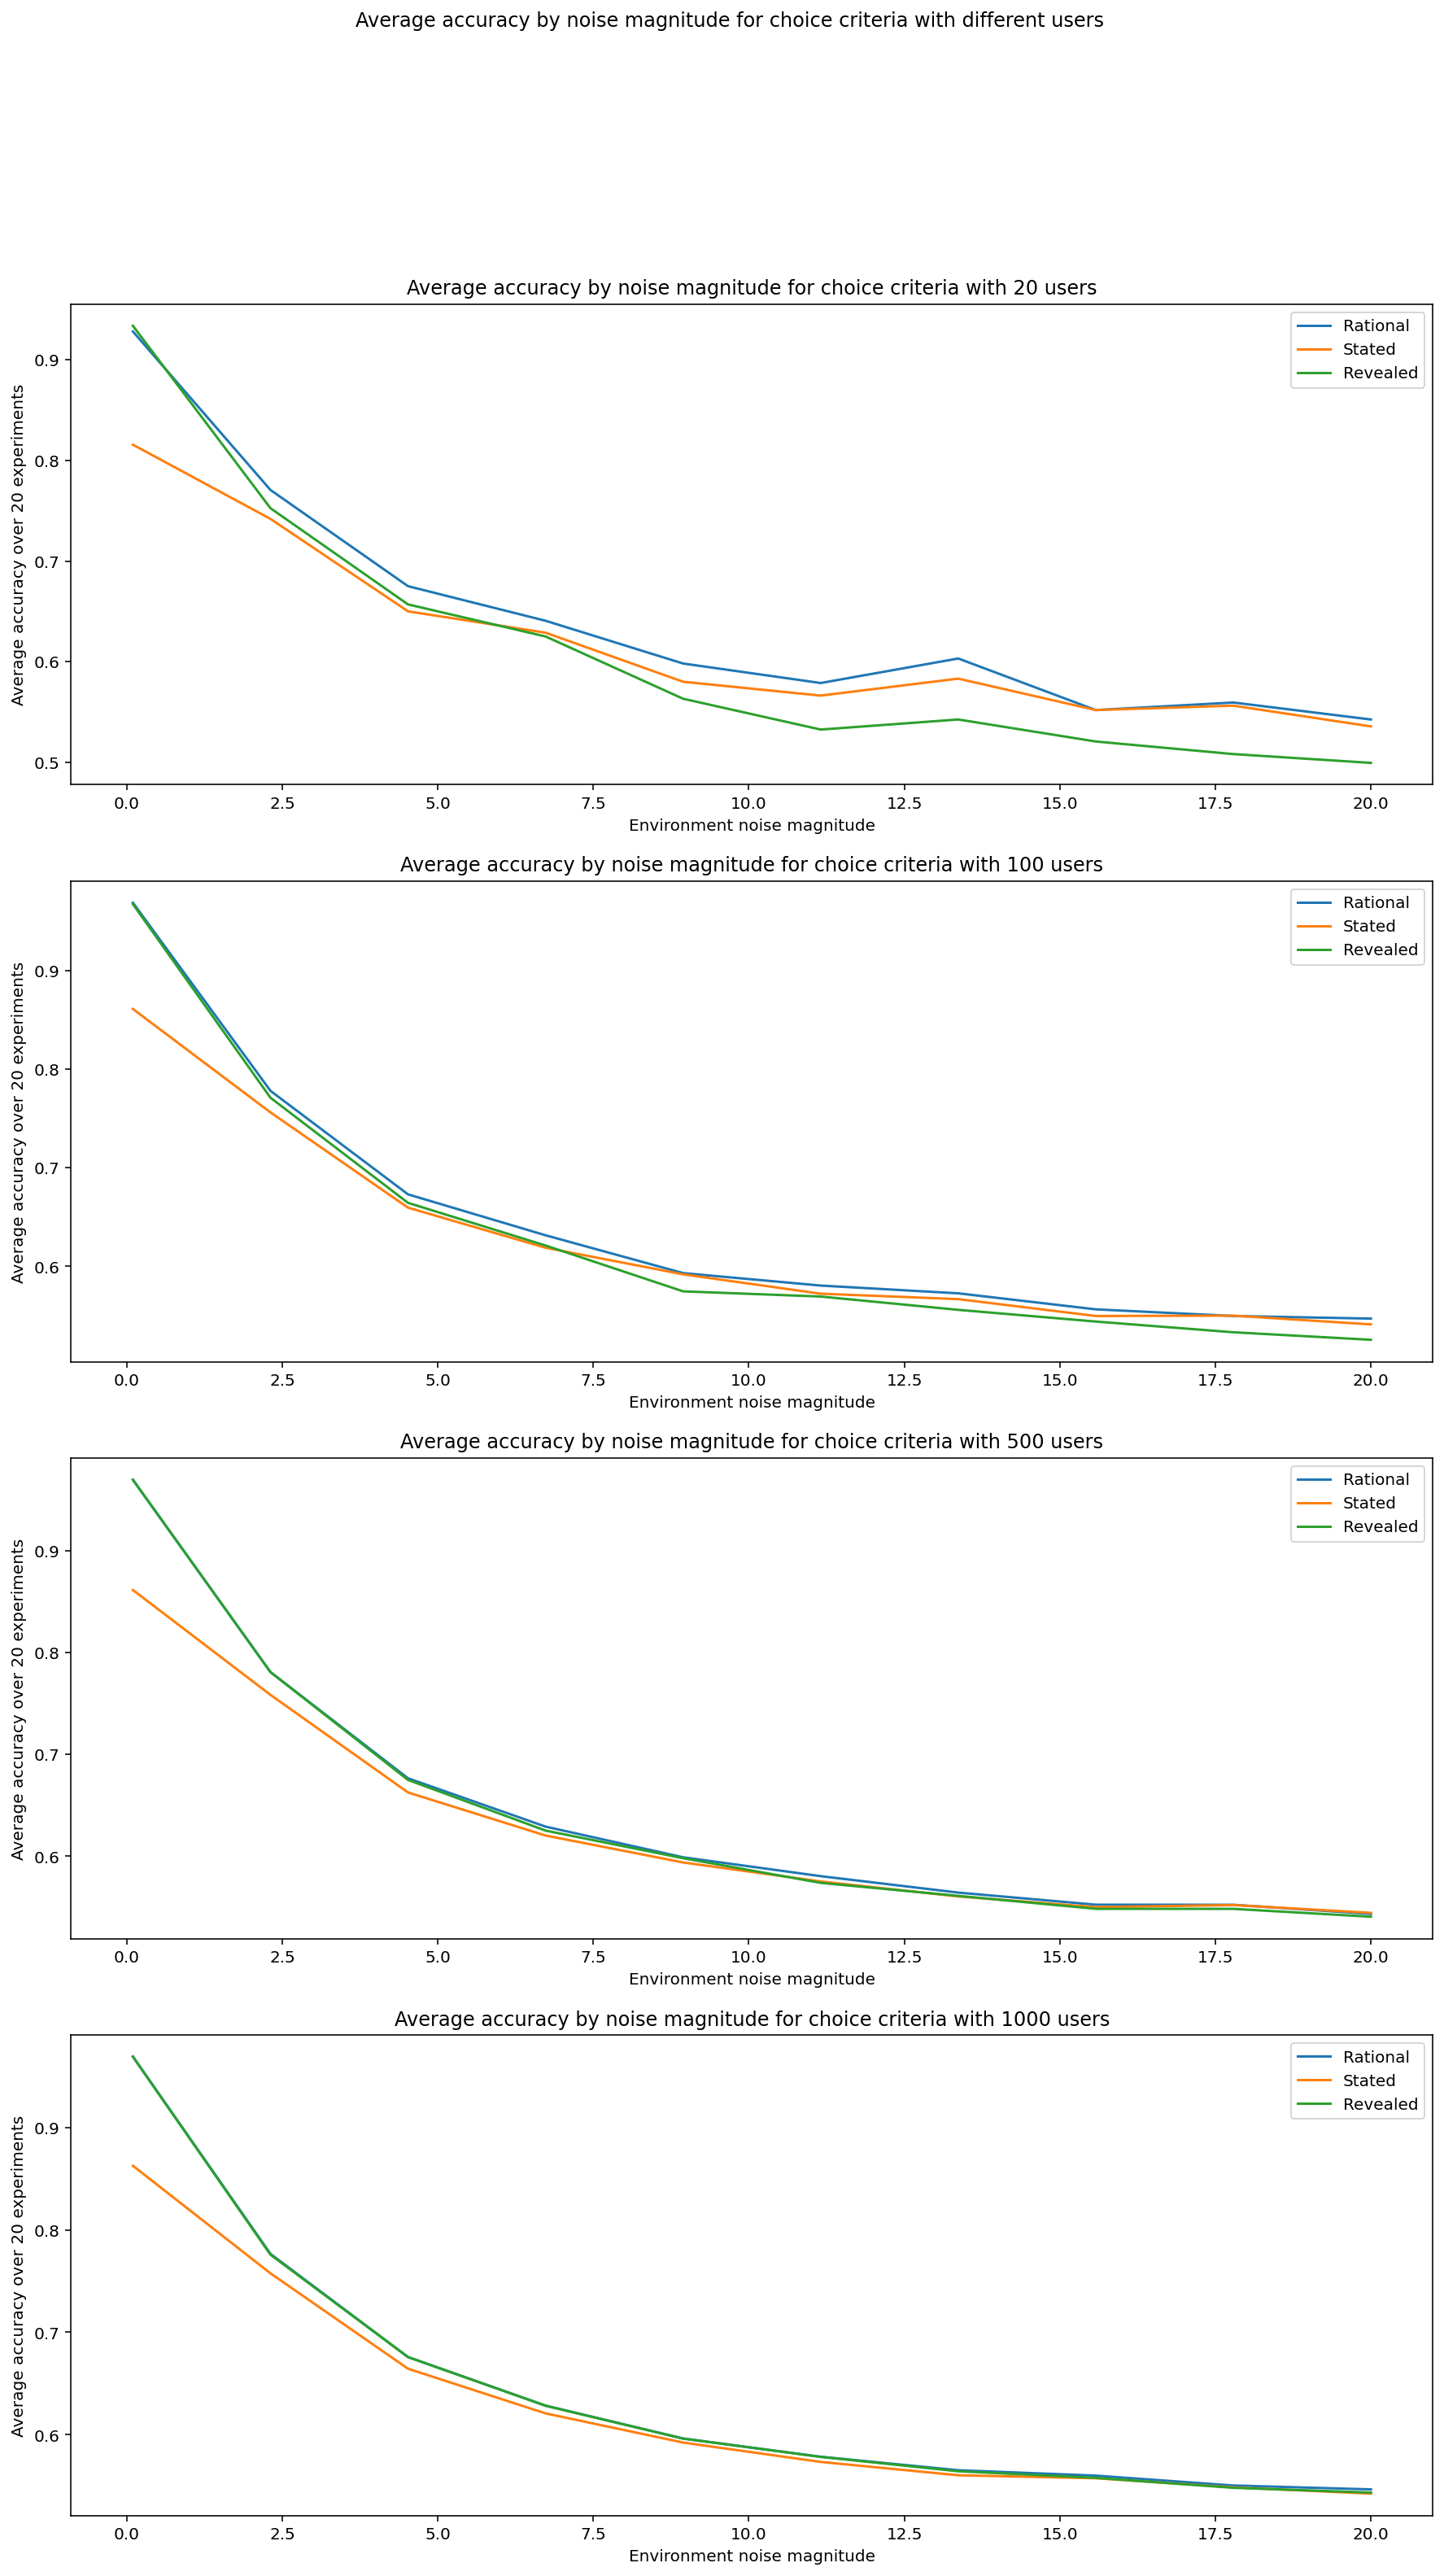

In [30]:
fig, ax = plt.subplots(4,1)
fig.set_size_inches(15,25)
fig.suptitle(f'Average accuracy by noise magnitude for choice criteria with different users')

ax[0].plot(noise_scale_vec, avg_accuracy_rational, label='Rational')
ax[0].plot(noise_scale_vec, avg_accuracy_stated, label='Stated')
ax[0].plot(noise_scale_vec, avg_accuracy_revealed, label='Revealed')
ax[0].set_title(f'Average accuracy by noise magnitude for choice criteria with 20 users')
ax[0].set_xlabel('Environment noise magnitude')
ax[0].set_ylabel(f'Average accuracy over {task1_n_repetitions} experiments') # , rotation='horizontal') # There are many parameters - we should explore the documantation to find what we seek
ax[0].legend();

ax[1].plot(noise_scale_vec, avg_accuracy_rational_100, label='Rational')
ax[1].plot(noise_scale_vec, avg_accuracy_stated_100, label='Stated')
ax[1].plot(noise_scale_vec, avg_accuracy_revealed_100, label='Revealed')
ax[1].set_title(f'Average accuracy by noise magnitude for choice criteria with 100 users')
ax[1].set_xlabel('Environment noise magnitude')
ax[1].set_ylabel(f'Average accuracy over {task1_n_repetitions} experiments') # , rotation='horizontal') # There are many parameters - we should explore the documantation to find what we seek
ax[1].legend();

ax[2].plot(noise_scale_vec, avg_accuracy_rational_500, label='Rational')
ax[2].plot(noise_scale_vec, avg_accuracy_stated_500, label='Stated')
ax[2].plot(noise_scale_vec, avg_accuracy_revealed_500, label='Revealed')
ax[2].set_title(f'Average accuracy by noise magnitude for choice criteria with 500 users')
ax[2].set_xlabel('Environment noise magnitude')
ax[2].set_ylabel(f'Average accuracy over {task1_n_repetitions} experiments') # , rotation='horizontal') # There are many parameters - we should explore the documantation to find what we seek
ax[2].legend();

ax[3].plot(noise_scale_vec, avg_accuracy_rational_1000, label='Rational')
ax[3].plot(noise_scale_vec, avg_accuracy_stated_1000, label='Stated')
ax[3].plot(noise_scale_vec, avg_accuracy_revealed_1000, label='Revealed')
ax[3].set_title(f'Average accuracy by noise magnitude for choice criteria with 1000 users')
ax[3].set_xlabel('Environment noise magnitude')
ax[3].set_ylabel(f'Average accuracy over {task1_n_repetitions} experiments') # , rotation='horizontal') # There are many parameters - we should explore the documantation to find what we seek
ax[3].legend();


From the above graphs, we can see that repeating the experiment for more users results in smoother graphs, and that the graphs coincide as more noise is added. Another perspective for this result is that in general, training a linear regressor over less than 20 samples (train is a subset of 20 users) is just not enough data, especially when noise is added. 

Moreover, as we increased the number of users, the trend is changing and the revealed accuracy even outperforms the stated by a small amount. For example, looking at the graph for 500 users, we can see that until we reach a noise magnitude of about 10, the revealed accuracy is higher, and from that point forward we see the coinciding lines we mentioned before. This is in cotrast to the 20 users graph, where for $\sigma$ higher than about 7, the revealed accuracy is worse than the stated and rational accuracies.

Am important observation is that adding more data didn't help with overall accuracy when $\sigma$ increases, differently than our inital hypothesis.
This behavior demonstrates that adding more data helps reduce the noise effect on the variance between the trained models - so for example when $\sigma$ goes to inf, revealed can also serve as a proxy to rational, not only stated.


The previous experiments we ran led us to think it would be interesting to look at the effect of adding more users when calculating the welfare. The interesting thing about the results is that the revealed choice welfare improves significantly as we increase the number of users, so much so that for 1000 users, it's right between the rational and the stated welfare. 
We had a hard time trying to explain these results, but would be happy to discuss further with the course staff.  

In [31]:
noise_scale_vec = np.linspace(0.1,20,10)
task1_n_repetitions = 20
task1_n_users = 100

## YOUR SOLUTION
avg_welfare_rational_100= np.zeros(noise_scale_vec.shape[0])
avg_welfare_stated_100 = np.zeros(noise_scale_vec.shape[0])
avg_welfare_revealed_100 = np.zeros(noise_scale_vec.shape[0])

for i, noise in enumerate(noise_scale_vec):
    for rep in range(task1_n_repetitions):
        noisy_choice_env = NoisyBinaryChoiceEnvironment(noise_scale=noise)
        train_df, eval_df = noisy_choice_env.generate_train_eval_datasets(n_users=task1_n_users)
        feature_columns = noisy_choice_env.get_feature_columns()
        x_train = train_df[feature_columns]
        x_test = eval_df[feature_columns]

        y_train_rational = train_df['rational_choice']
        model = sklearn.linear_model.LogisticRegression().fit(
            X=x_train,
            y=y_train_rational,
        )
        avg_welfare_rational_100[i] += welfare(model.predict, eval_df, feature_columns, 'true_value')

        y_train_stated = train_df['stated_choice']
        model = sklearn.linear_model.LogisticRegression().fit(
            X=x_train,
            y=y_train_stated,
        )
        avg_welfare_stated_100[i] += welfare(model.predict, eval_df, feature_columns, 'true_value')

        y_train_revealed = train_df['revealed_choice']
        model = sklearn.linear_model.LogisticRegression().fit(
            X=x_train,
            y=y_train_revealed,
        )
        avg_welfare_revealed_100[i] += welfare(model.predict, eval_df, feature_columns, 'true_value')
avg_welfare_rational_100 = avg_welfare_rational_100/task1_n_repetitions
avg_welfare_stated_100 = avg_welfare_stated_100/task1_n_repetitions
avg_welfare_revealed_100 = avg_welfare_revealed_100/task1_n_repetitions

In [32]:
noise_scale_vec = np.linspace(0.1,20,10)
task1_n_repetitions = 20
task1_n_users = 500

## YOUR SOLUTION
avg_welfare_rational_500= np.zeros(noise_scale_vec.shape[0])
avg_welfare_stated_500 = np.zeros(noise_scale_vec.shape[0])
avg_welfare_revealed_500 = np.zeros(noise_scale_vec.shape[0])

for i, noise in enumerate(noise_scale_vec):
    for rep in range(task1_n_repetitions):
        noisy_choice_env = NoisyBinaryChoiceEnvironment(noise_scale=noise)
        train_df, eval_df = noisy_choice_env.generate_train_eval_datasets(n_users=task1_n_users)
        feature_columns = noisy_choice_env.get_feature_columns()
        x_train = train_df[feature_columns]
        x_test = eval_df[feature_columns]

        y_train_rational = train_df['rational_choice']
        model = sklearn.linear_model.LogisticRegression().fit(
            X=x_train,
            y=y_train_rational,
        )
        avg_welfare_rational_500[i] += welfare(model.predict, eval_df, feature_columns, 'true_value')

        y_train_stated = train_df['stated_choice']
        model = sklearn.linear_model.LogisticRegression().fit(
            X=x_train,
            y=y_train_stated,
        )
        avg_welfare_stated_500[i] += welfare(model.predict, eval_df, feature_columns, 'true_value')

        y_train_revealed = train_df['revealed_choice']
        model = sklearn.linear_model.LogisticRegression().fit(
            X=x_train,
            y=y_train_revealed,
        )
        avg_welfare_revealed_500[i] += welfare(model.predict, eval_df, feature_columns, 'true_value')
avg_welfare_rational_500 = avg_welfare_rational_500/task1_n_repetitions
avg_welfare_stated_500 = avg_welfare_stated_500/task1_n_repetitions
avg_welfare_revealed_500 = avg_welfare_revealed_500/task1_n_repetitions

In [33]:
noise_scale_vec = np.linspace(0.1,20,10)
task1_n_repetitions = 20
task1_n_users = 1000

## YOUR SOLUTION
avg_welfare_rational_1000= np.zeros(noise_scale_vec.shape[0])
avg_welfare_stated_1000 = np.zeros(noise_scale_vec.shape[0])
avg_welfare_revealed_1000 = np.zeros(noise_scale_vec.shape[0])

for i, noise in enumerate(noise_scale_vec):
    for rep in range(task1_n_repetitions):
        noisy_choice_env = NoisyBinaryChoiceEnvironment(noise_scale=noise)
        train_df, eval_df = noisy_choice_env.generate_train_eval_datasets(n_users=task1_n_users)
        feature_columns = noisy_choice_env.get_feature_columns()
        x_train = train_df[feature_columns]
        x_test = eval_df[feature_columns]

        y_train_rational = train_df['rational_choice']
        model = sklearn.linear_model.LogisticRegression().fit(
            X=x_train,
            y=y_train_rational,
        )
        avg_welfare_rational_1000[i] += welfare(model.predict, eval_df, feature_columns, 'true_value')

        y_train_stated = train_df['stated_choice']
        model = sklearn.linear_model.LogisticRegression().fit(
            X=x_train,
            y=y_train_stated,
        )
        avg_welfare_stated_1000[i] += welfare(model.predict, eval_df, feature_columns, 'true_value')

        y_train_revealed = train_df['revealed_choice']
        model = sklearn.linear_model.LogisticRegression().fit(
            X=x_train,
            y=y_train_revealed,
        )
        avg_welfare_revealed_1000[i] += welfare(model.predict, eval_df, feature_columns, 'true_value')
avg_welfare_rational_1000 = avg_welfare_rational_1000/task1_n_repetitions
avg_welfare_stated_1000 = avg_welfare_stated_1000/task1_n_repetitions
avg_welfare_revealed_1000 = avg_welfare_revealed_1000/task1_n_repetitions

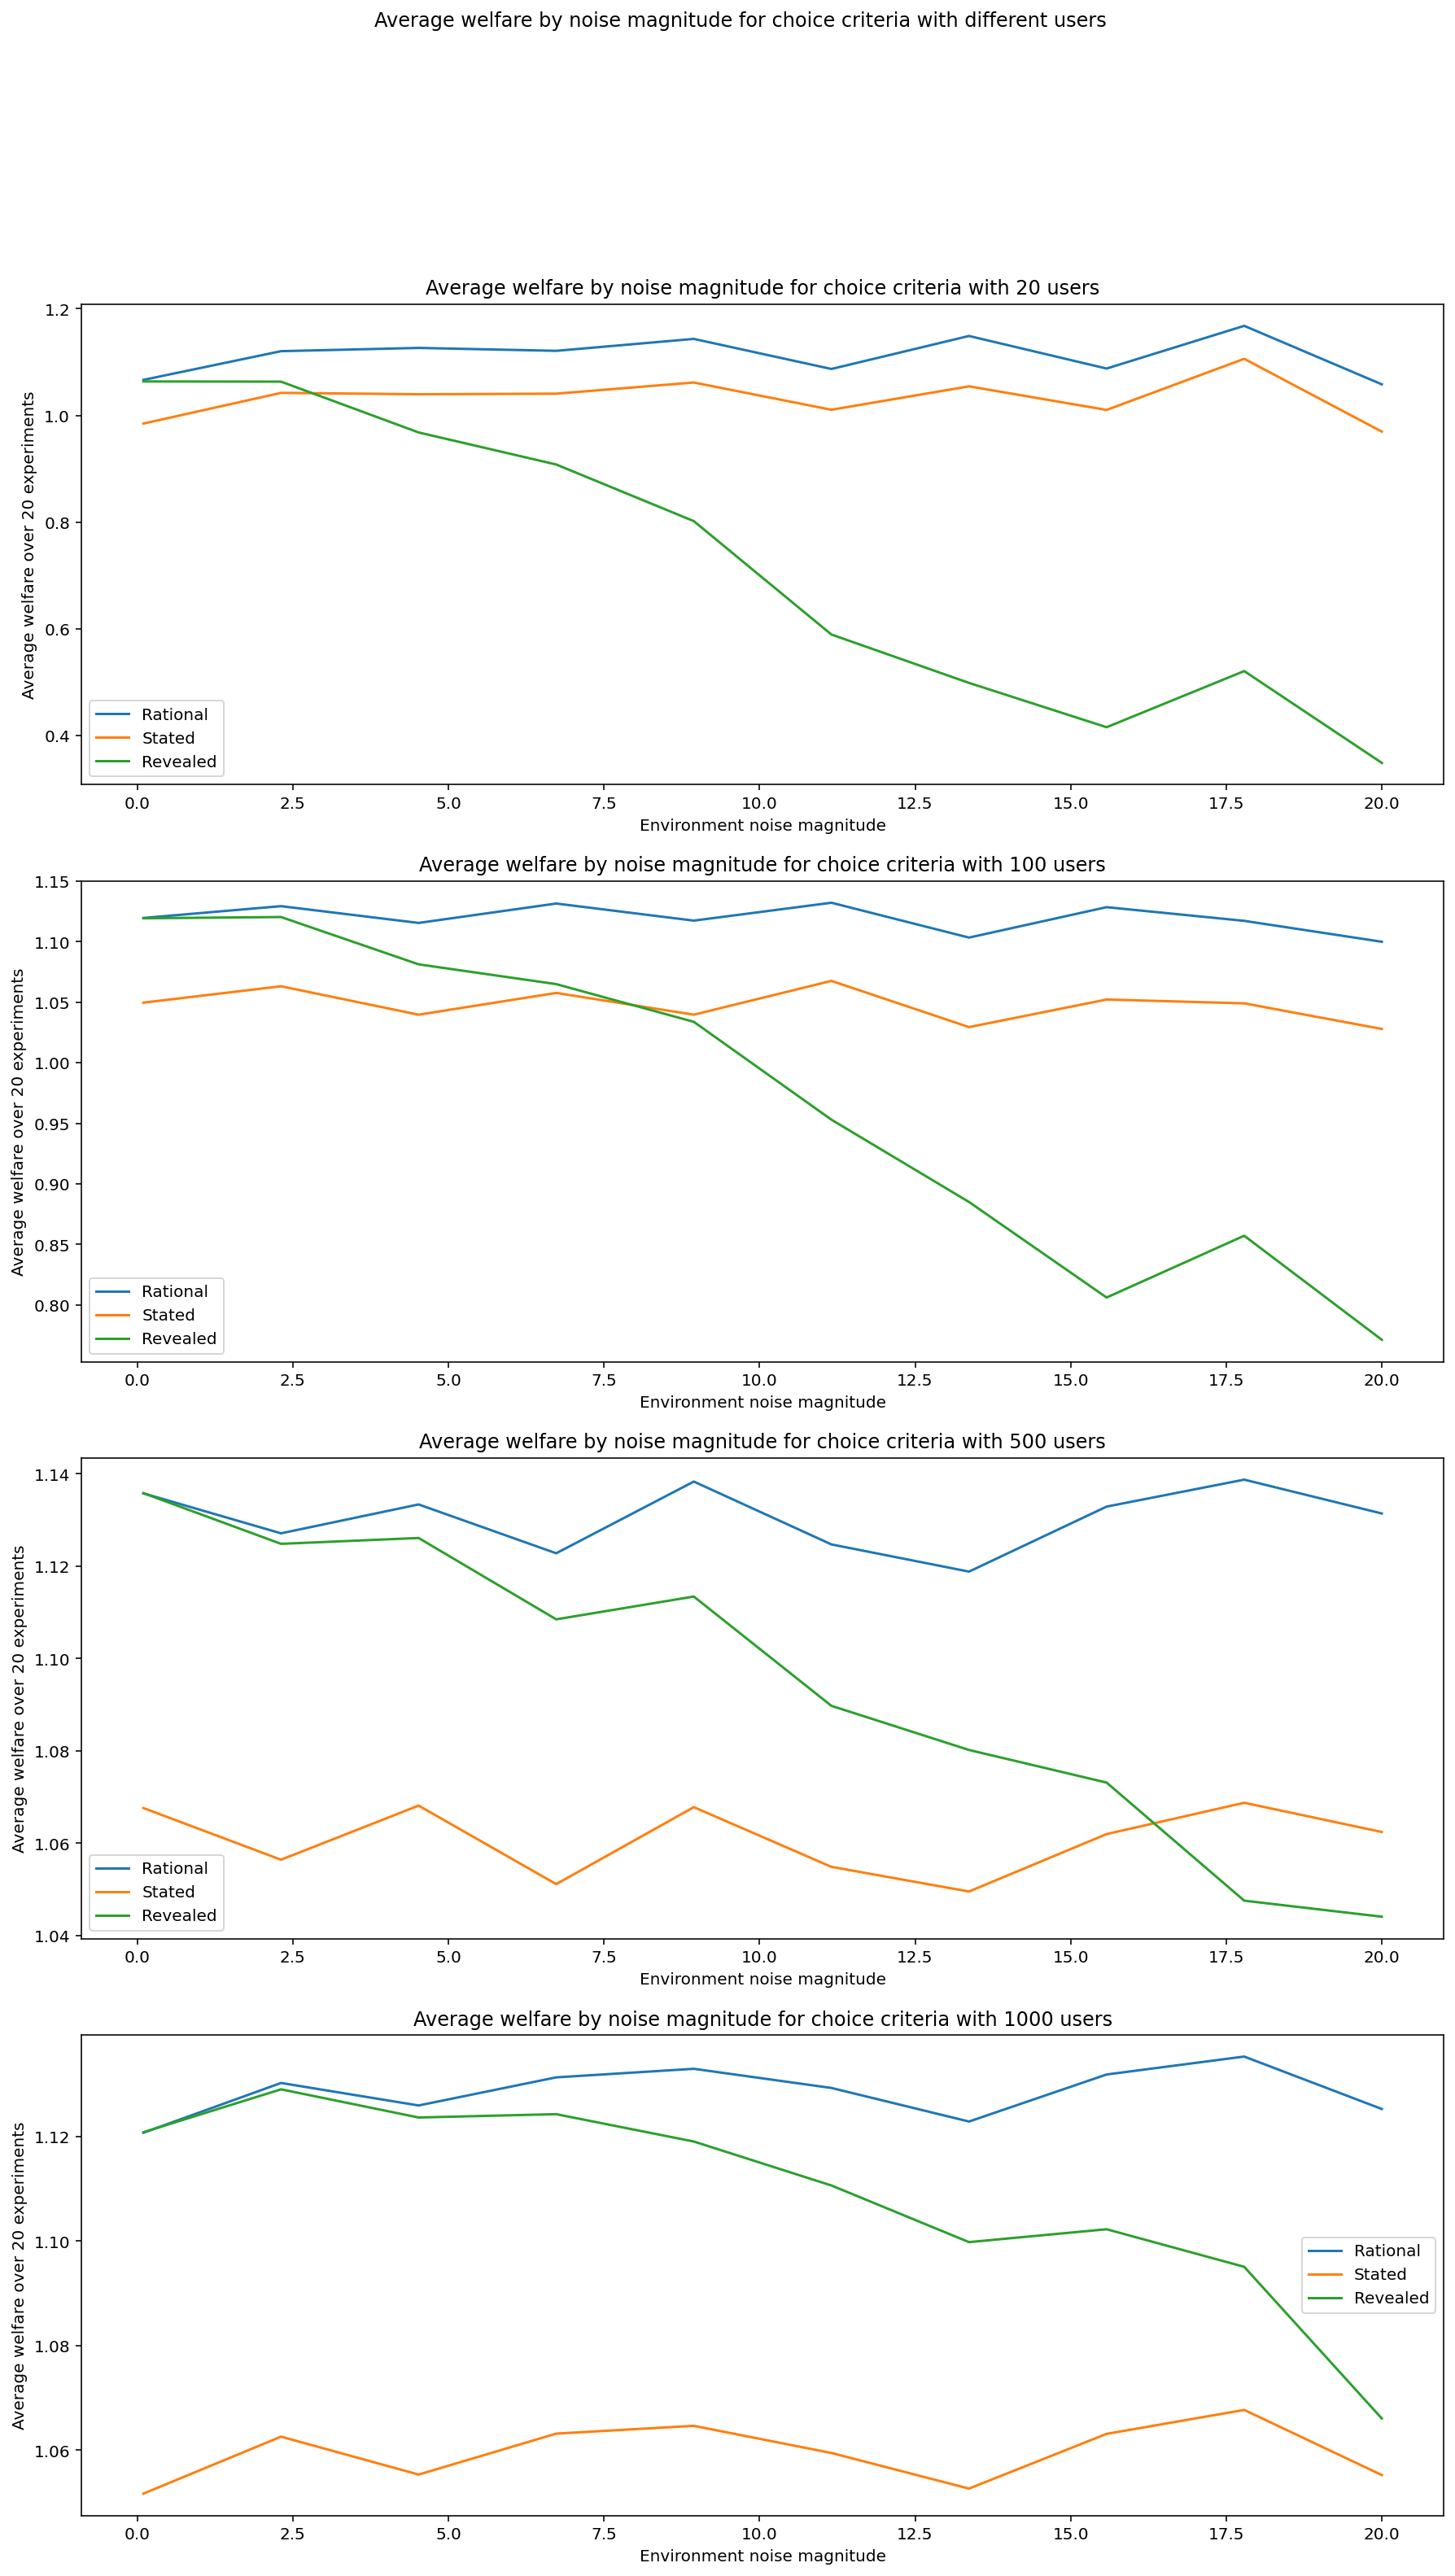

In [34]:
fig, ax = plt.subplots(4,1)
fig.set_size_inches(15,25)
fig.suptitle(f'Average welfare by noise magnitude for choice criteria with different users')

ax[0].plot(noise_scale_vec, avg_welfare_rational, label='Rational')
ax[0].plot(noise_scale_vec, avg_welfare_stated, label='Stated')
ax[0].plot(noise_scale_vec, avg_welfare_revealed, label='Revealed')
ax[0].set_title(f'Average welfare by noise magnitude for choice criteria with 20 users')
ax[0].set_xlabel('Environment noise magnitude')
ax[0].set_ylabel(f'Average welfare over {task1_n_repetitions} experiments') # , rotation='horizontal') # There are many parameters - we should explore the documantation to find what we seek
ax[0].legend();

ax[1].plot(noise_scale_vec, avg_welfare_rational_100, label='Rational')
ax[1].plot(noise_scale_vec, avg_welfare_stated_100, label='Stated')
ax[1].plot(noise_scale_vec, avg_welfare_revealed_100, label='Revealed')
ax[1].set_title(f'Average welfare by noise magnitude for choice criteria with 100 users')
ax[1].set_xlabel('Environment noise magnitude')
ax[1].set_ylabel(f'Average welfare over {task1_n_repetitions} experiments') # , rotation='horizontal') # There are many parameters - we should explore the documantation to find what we seek
ax[1].legend();

ax[2].plot(noise_scale_vec, avg_welfare_rational_500, label='Rational')
ax[2].plot(noise_scale_vec, avg_welfare_stated_500, label='Stated')
ax[2].plot(noise_scale_vec, avg_welfare_revealed_500, label='Revealed')
ax[2].set_title(f'Average welfare by noise magnitude for choice criteria with 500 users')
ax[2].set_xlabel('Environment noise magnitude')
ax[2].set_ylabel(f'Average welfare over {task1_n_repetitions} experiments') # , rotation='horizontal') # There are many parameters - we should explore the documantation to find what we seek
ax[2].legend();

ax[3].plot(noise_scale_vec, avg_welfare_rational_1000, label='Rational')
ax[3].plot(noise_scale_vec, avg_welfare_stated_1000, label='Stated')
ax[3].plot(noise_scale_vec, avg_welfare_revealed_1000, label='Revealed')
ax[3].set_title(f'Average welfare by noise magnitude for choice criteria with 1000 users')
ax[3].set_xlabel('Environment noise magnitude')
ax[3].set_ylabel(f'Average welfare over {task1_n_repetitions} experiments') # , rotation='horizontal') # There are many parameters - we should explore the documantation to find what we seek
ax[3].legend();


# Task \#2: Rationality assumptions in loss-averse environments

## Introduction

In this task, we will evaluate the performance of a standard ("rational") prediction model when decision-makers are loss-averse. 

In this section, users make decisions under uncertainty. Each user has two inherent utility functions, $u_a$ and $u_b$, and a probability parameter $p\in\left[0,1\right]$. The user's utility from consuming an item $x$ is:
- $u_a(x)\in\mathbb{R}$ with probability $p$, and 
- $u_b(x)\in\mathbb{R}$ with probability $(1-p)$. 

When user behavior is *rational*, the decision is made by comparing the *expected utility* of the two alternatives:

$$
y_\text{rational}=\begin{cases}
1&p \cdot u_a(x) + (1-p) \cdot u_b(x) \ge 0\\
0&\text{otherwise}
\end{cases}
$$

When user decisions are subject to *behavioral bias*, choice deviates from the expected optiumum. In particular, we will focus on a setting where the users are *loss-averse*. In the spirit of Prospect Theory [[1](https://en.wikipedia.org/wiki/Prospect_theory)], we assume there exist two functions $\pi, v$ such that the perceived value from consuming the item is:

$$
\begin{align}
V_{\pi, v}\left(x\right)
&=\sum_{i=1}^2 \pi\left(p_i\right) v\left(u_i(x)\right)\\
&=\pi(p) \cdot v(u_a(x)) + \pi(1-p) \cdot v(u_b(x))
\end{align}
$$

The function $v$ captures the loss-aversion property, and it is s-shaped and asymmetrical. The function $\pi$ is a probability weighting function and captures the idea that people tend to overreact to small probability events, but underreact to large probabilities. Assuming $v(0)=0$, consumption decisions are made according to the following rule:

$$
y_\text{prospect}=\begin{cases}
1&V_{\pi,v}(x) \ge 0\\
0&\text{otherwise}
\end{cases}
$$

## Exercise 2.1: Understanding the functional form of $v$


The user valuation bias can be modeled using an S-shaped assymetrical function $v:\mathbb{R}\to\mathbb{R}$. Following [[2](https://www.econstor.eu/bitstream/10419/87132/1/472515071.pdf)], we assume that $v$ is a power S-shaped utility function, and its functional form is given by:


$$
v(u)=\begin{cases}
u^\alpha& u \ge 0 \\
-\gamma \left(-u\right)^\beta& u < 0
\end{cases}
$$

where $u=u(x)$ is the objective utility from consuming item $x$, and $0< \alpha \le \beta \le 1$, $\gamma\ge 1$ are constants.


**Implementation**

Implement the class `PowerLossAversion`. The class constructor will receive three scalar constants `alpha`, `beta`, `gamma`.  The `__call__` function will calculate $v(u)$ as defined above.

Hint: Make your code more efficient by using numpy vectorized operations, and avoid explicit loops and if statements.

🔵 **Answer**:

In [35]:
class PowerLossAversion:
    """
    The power S-shaped utility function, as defined by Maggi (2014)
    """
    def __init__(self, alpha, beta, gamma):
        assert 0 < alpha <= 1
        assert 0 < beta <= 1
        assert alpha <= beta
        assert gamma >= 1
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
    
    def __call__(self, u):
        """
        Compute the power S-shaped utility function for a vector of utilities.

        Parameters
        ----------
        u : ndarray of shape (n)

        Output
        ------
        v : ndarray of shape (n)
        """
        ## YOUR SOLUTION
        v = u.copy()
        v[v>=0] = np.power(v[v>=0], self.alpha)
        v[v<0] = np.power(-v[v<0], self.beta)*-self.gamma
        return v

Using the implementation above, plot the function $\nu$ for values of $u$ in the range $[-2,2]$, and for the given sets of parameters:

  1. $\left(\alpha_1, \beta_1, \gamma_1\right) = \left(1, 1, 1\right)$
  2. $\left(\alpha_2, \beta_2, \gamma_2\right) = \left(1, 1, 2.5\right)$
  3. $\left(\alpha_3, \beta_3, \gamma_3\right) = \left(0.88, 0.88, 2.5\right)$
  4. $\left(\alpha_4, \beta_4, \gamma_4\right) = \left(0.2, 0.88, 1.8\right)$

🔵 **Answer**:

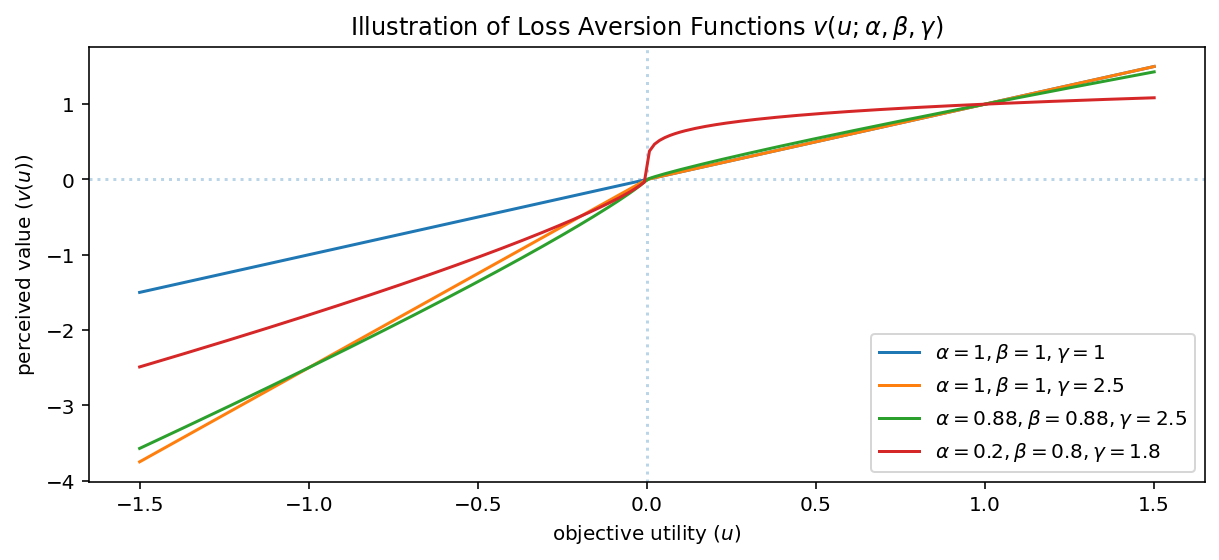

In [36]:
prospect_params_lst = [
    (1,1,1),
    (1,1,2.5),
    (0.88,0.88,2.5),
    (0.2,0.8,1.8),
]

fig,ax = plt.subplots(figsize=(10,4))

u_vec = np.linspace(-1.5,1.5,200)
for alpha, beta, gamma in prospect_params_lst:
    v = PowerLossAversion(alpha, beta, gamma)
    perceived_value = v(u_vec)
    ax.plot(
        u_vec,
        perceived_value,
        label=f'$\\alpha={alpha}, \\beta={beta}, \\gamma={gamma}$',
    )

ax.set_title('Illustration of Loss Aversion Functions $v(u; \\alpha, \\beta, \\gamma)$')
ax.set_xlabel('objective utility ($u$)')
ax.set_ylabel(r'perceived value ($v(u)$)')
ax.axhline(0,linestyle=':',zorder=-1,alpha=0.3)
ax.axvline(0,linestyle=':',zorder=-1,alpha=0.3)
ax.legend()


Given the results - 

What type of behavior is characterized by the curve parametrized by $\left(\alpha, \beta, \gamma\right) = \left(1, 1, 1\right)$?

🔵 **Answer**:

The graph is linear, corresponding with rational behavior.  



What is the interpretation of the parameter $\gamma$? Which behavioral traits are represented by high/low values of $\gamma$? What aspect of prospect theory does it correspond to?

🔵 **Answer**:

The parameter $\gamma$ corresponds to how loss averse is the user. A high value of $\gamma$ means the user is very loss averse, and a low value (close to 1) means the user is more rational regarding the loss.



What is the meaning of the parameters $\alpha,\beta$? What aspects of prospect theory do they correspond to?

🔵 **Answer**:

The parameters $\alpha,\beta$ correspond to the diminishing effect of marginal utility. The smaller their value, the quicker the diminishing takes effect (from a lower absolute utility value).



## Exercise 2.2: Simulating user behavior

**Example**

For the implementation of this behavioral model, we inherit from the `InnerProductTrueValueEnvironment` defined at the start of this notebook, and define the following abstract class:



In [37]:
class ProspectEnvironment(InnerProductTrueValueEnvironment):
    def _generate_user_attributes(self, n_users):
        """
        Generate latent parameters for users.

        Parameters
        ----------
        n_users : int

        Output
        ------
        users : ndarray of shape (n_outcomes, n_users, n_features)
        """
        return np.stack(
            [
                np.random.normal(
                    loc=1,
                    scale=0.1,
                    size=(n_users, self.n_features),
                ),
                np.random.normal(
                    loc=-0.1,
                    scale=0.1,
                    size=(n_users, self.n_features),
                ),
            ],
            axis=0,
        )

We can inherit from these classes to create specific behavioral models. For example, here is a class which models unbiased decision making:

In [38]:
class RationalProspectEnvironmentExample(ProspectEnvironment):
    def __init__(self):
        p_a = np.random.uniform(0,1)
        self.p = [p_a, 1-p_a]
        super().__init__()

    def _choice(self, users, items):
        """
        Simulate choice

        Parameters
        ----------
        users : ndarray of shape (n_outcomes, n_users, n_features)
        items : ndarray of shape (n_users, n_observations, n_features)

        Output
        ------
        choice : Dict[str -> ndarray of shape(n_users, observations_per_user)]
        """
        # Calculate true value based on inner product
        u_a = self._true_value(users[0], items)
        u_b = self._true_value(users[1], items)
        return {
            'u_a': u_a,  # u_a(x)
            'u_b': u_b,  # u_b(x)
            'rational_choice': self.p[0]*u_a + self.p[1]*u_b >= 0,
        }

rational_env_example = RationalProspectEnvironmentExample()
rational_train_df, rational_eval_df = rational_env_example.generate_train_eval_datasets(n_users=100)
rational_train_df.sample(5)

,user_id,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,u_a,u_b,rational_choice
156,15,0.348394,-0.521972,-0.447575,-0.080985,0.867490,-0.315342,1.081849,-0.948881,-0.124291,0.091577,True
439,43,1.149760,-0.572300,-0.446795,0.052289,1.244223,0.168988,0.398129,1.804873,3.963915,-0.284706,True
260,26,0.729762,-0.829716,0.022718,1.393506,0.637440,0.378612,-0.130524,0.482852,3.090942,-0.199204,True
10,1,-0.674902,0.424690,1.971283,-0.440504,-1.701433,1.667924,0.966817,-1.040224,0.927316,0.003123,True
506,50,-0.330630,-0.296211,-0.796639,-0.268406,-0.527912,0.758514,-0.805128,-1.447152,-4.037410,0.653145,True


**Implementation**

Based on the example above, implement the `BehavioralProspectEnvironment` class for simulating choice in a behavioral environment:
* Class should inherit from `ProspectEnvironment`
* Prospect value function $v(u)$ and a probability weighting function $\pi(p)$ should be given in the class constructor.
* Generate the probability $p$ uniformly in $[0, 1]$.
* Implement the binary choice inside the `_choice` function. Function returns a dictionary mapping column names to numpy arrays containing their contents (see example above).

🔵 **Answer**:

In [48]:
## YOUR SOLUTION
class BehavioralProspectEnvironment(ProspectEnvironment):
    def __init__(self, v, pi = lambda x: x):
        p_a = np.random.uniform(0,1)
        self.p = [p_a, 1-p_a]
        super().__init__()
        self.v = v
        self.pi = pi

    def _choice(self, users, items):
        """
        Simulate choice

        Parameters
        ----------
        users : ndarray of shape (n_outcomes, n_users, n_features)
        items : ndarray of shape (n_users, n_observations, n_features)

        Output
        ------
        choice : Dict[str -> ndarray of shape(n_users, observations_per_user)]
        """
        # Calculate true value based on inner product
        u_a = self._true_value(users[0], items)
        u_b = self._true_value(users[1], items)
        return {
            'behavioral_bias_u_a': self.v(u_a),  # u_a(x)
            'behavioral_bias_u_b': self.v(u_b),  # u_b(x)
            'behavioral_bias_choice': self.pi(self.p[0])*self.v(u_a) + self.pi(self.p[1])*self.v(u_b) >= 0,
        }

## Exercise 2.3: Predicting under behavioral bias



For each set of behavioral parameters $\left(\alpha_1, \beta_1, \gamma_1\right),\dots,\left(\alpha_4, \beta_4, \gamma_4\right)$ given above, and for a neutral probability weighting ($\pi(p)=p$), train and evaluate a Logistic Regression model on data generated by the corresponding `BehavioralProspectEnvironment`, with `n_users=100`.

Report evaluation set accuracy for each set of parameters, averaged over 10 repetitions of the simulation.

🔵 **Answer**:

In [52]:
task_2_3_n_repetitions = 10
task_2_3_n_users = 100


prospect_params_dict = {
    (1,1,1): 0,
    (1,1,2.5): 0,
    (0.88,0.88,2.5): 0,
    (0.2,0.8,1.8): 0
}

for index, (alpha, beta, gamma) in enumerate(prospect_params_dict.keys()):
    v = PowerLossAversion(alpha, beta, gamma)
    for rep in range(task_2_3_n_repetitions):
        prospect_env = BehavioralProspectEnvironment(v)
        train_df, eval_df = prospect_env.generate_train_eval_datasets(n_users=task_2_3_n_users)
        feature_columns = prospect_env.get_feature_columns()
        x_train = train_df[feature_columns]
        x_test = eval_df[feature_columns]
        y_test = eval_df['behavioral_bias_choice']

        y_train_rational = train_df['behavioral_bias_choice']
        model = sklearn.linear_model.LogisticRegression().fit(
            X=x_train,
            y=y_train_rational,
        )
        prospect_params_dict[(alpha, beta, gamma)] += model.score(x_test, y_test)
    prospect_params_dict[(alpha, beta, gamma)] = prospect_params_dict[(alpha, beta, gamma)]/task_2_3_n_repetitions

In [54]:
for params, res in prospect_params_dict.items():
    print(f"Evaluation set accuracy averaged over 10 repetitions of the simulation for params {params} is {res}")


Evaluation set accuracy averaged over 10 repetitions of the simulation for params (1, 1, 1) is 0.9412499999999999
Evaluation set accuracy averaged over 10 repetitions of the simulation for params (1, 1, 2.5) is 0.8640000000000001
Evaluation set accuracy averaged over 10 repetitions of the simulation for params (0.88, 0.88, 2.5) is 0.81325
Evaluation set accuracy averaged over 10 repetitions of the simulation for params (0.2, 0.8, 1.8) is 0.8220000000000001


Plot a line graph representing the accuracy, for fixed $\alpha=\beta=1$ and variable $\gamma\in[1,15]$. Repeat each simulation 10 times for each value of $\gamma$, and use the average value for the plot.

🔵 **Answer**:

In [66]:
alpha = 1
beta = 1
gamma_vec = np.linspace(1,5,10)
res_gamma_vec = np.zeros(gamma_vec.shape[0])
task_2_3_2_n_repetitions = task_2_3_n_repetitions

## YOUR SOLUTION
for i, gamma in enumerate(gamma_vec):
    v = PowerLossAversion(alpha, beta, gamma)
    for rep in range(task_2_3_2_n_repetitions):
        prospect_env = BehavioralProspectEnvironment(v)
        train_df, eval_df = prospect_env.generate_train_eval_datasets(n_users=task_2_3_n_users)
        feature_columns = prospect_env.get_feature_columns()
        x_train = train_df[feature_columns]
        x_test = eval_df[feature_columns]
        y_test = eval_df['behavioral_bias_choice']

        y_train_rational = train_df['behavioral_bias_choice']
        model = sklearn.linear_model.LogisticRegression().fit(
            X=x_train,
            y=y_train_rational,
        )
        res_gamma_vec[i] += model.score(x_test, y_test)
    res_gamma_vec[i] = res_gamma_vec[i]/task_2_3_2_n_repetitions

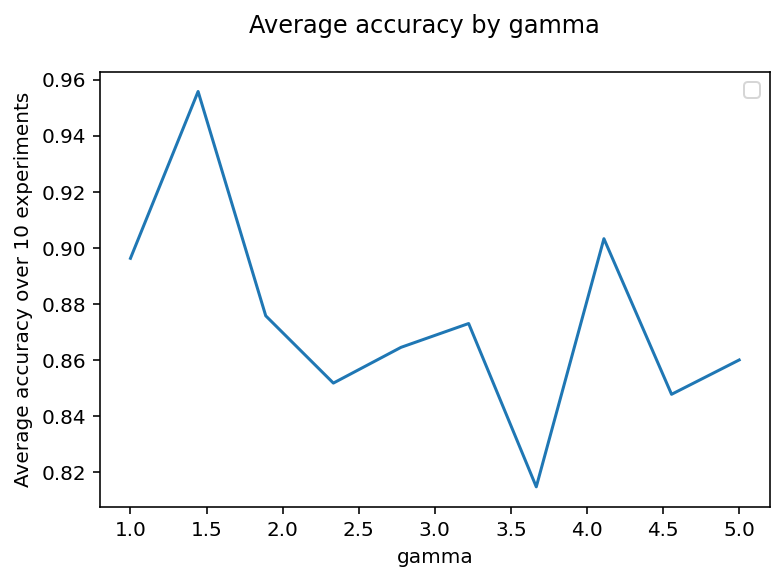

In [67]:
fig, ax = plt.subplots()
ax.plot(gamma_vec, res_gamma_vec)
fig.suptitle('Average accuracy by gamma')
ax.set_xlabel('gamma')
ax.set_ylabel(f'Average accuracy over {task_2_3_2_n_repetitions} experiments') # , rotation='horizontal') # There are many parameters - we should explore the documantation to find what we seek
ax.legend();

We can see a decreasing trend, but very noisy. In order to convince ourselves with this trend, we conducted the same experiment with 1000 repetitions, shown below:

In [64]:
alpha = 1
beta = 1
gamma_vec = np.linspace(1,5,10)
res_gamma_vec = np.zeros(gamma_vec.shape[0])
task_2_3_2_n_repetitions = task_2_3_n_repetitions*100

## YOUR SOLUTION
for i, gamma in enumerate(gamma_vec):
    v = PowerLossAversion(alpha, beta, gamma)
    for rep in range(task_2_3_2_n_repetitions):
        prospect_env = BehavioralProspectEnvironment(v)
        train_df, eval_df = prospect_env.generate_train_eval_datasets(n_users=task_2_3_n_users)
        feature_columns = prospect_env.get_feature_columns()
        x_train = train_df[feature_columns]
        x_test = eval_df[feature_columns]
        y_test = eval_df['behavioral_bias_choice']

        y_train_rational = train_df['behavioral_bias_choice']
        model = sklearn.linear_model.LogisticRegression().fit(
            X=x_train,
            y=y_train_rational,
        )
        res_gamma_vec[i] += model.score(x_test, y_test)
    res_gamma_vec[i] = res_gamma_vec[i]/task_2_3_2_n_repetitions

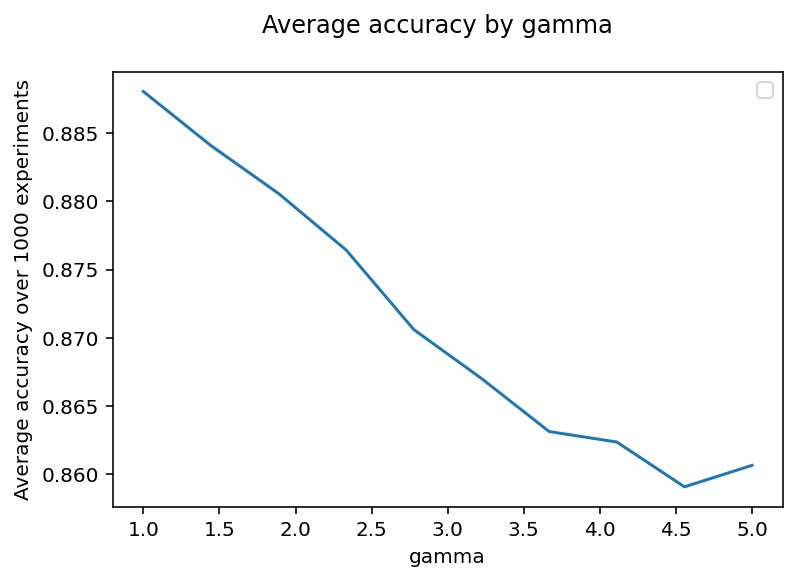

In [65]:
fig, ax = plt.subplots()
ax.plot(gamma_vec, res_gamma_vec)
fig.suptitle('Average accuracy by gamma')
ax.set_xlabel('gamma')
ax.set_ylabel(f'Average accuracy over {task_2_3_2_n_repetitions} experiments') # , rotation='horizontal') # There are many parameters - we should explore the documantation to find what we seek
ax.legend();

Explain the results: 

🔵 **Answer**:

We can clearly see a decreasing trend in accuracy in 1000 repititions as gamma increases. This makes sense, since the bigger gamma gets, the users are more loss averse, and hence their behavior differs more from the rational linear model. This makes it harder for a simple linear regressor to predict. 

Similarly, plot two lines representing the accuracy, for fixed $\gamma=\{1,2\}$ and variable $\alpha=\beta\in[0.5,1]$. Repeat each simulation 10 times for each value of $\gamma$, and average results.

🔵 **Answer**:

In [74]:
alphabeta_vec = np.linspace(0.4,1,20)
gamma_list=[1,2]
res = {
    1: np.zeros(alphabeta_vec.shape[0]),
    2: np.zeros(alphabeta_vec.shape[0]) 
}

## YOUR SOLUTION
for gamma in gamma_list:
    for i, alphabeta in enumerate(alphabeta_vec):
        v = PowerLossAversion(alphabeta, alphabeta, gamma)
        for rep in range(task_2_3_n_repetitions):
            prospect_env = BehavioralProspectEnvironment(v)
            train_df, eval_df = prospect_env.generate_train_eval_datasets(n_users=task_2_3_n_users)
            feature_columns = prospect_env.get_feature_columns()
            x_train = train_df[feature_columns]
            x_test = eval_df[feature_columns]
            y_test = eval_df['behavioral_bias_choice']

            y_train_rational = train_df['behavioral_bias_choice']
            model = sklearn.linear_model.LogisticRegression().fit(
                X=x_train,
                y=y_train_rational,
            )
            res[gamma][i] += model.score(x_test, y_test)
        res[gamma][i] =  res[gamma][i]/task_2_3_n_repetitions

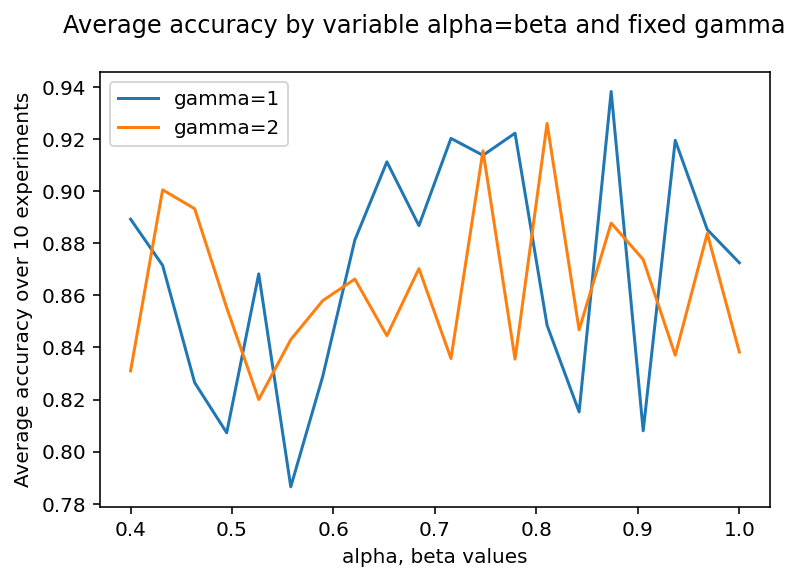

In [76]:
fig, ax = plt.subplots()
ax.plot(alphabeta_vec, res[1], label='gamma=1')
ax.plot(alphabeta_vec, res[2], label='gamma=2')
fig.suptitle('Average accuracy by variable alpha=beta and fixed gamma')
ax.set_xlabel('alpha, beta values')
ax.set_ylabel(f'Average accuracy over {task_2_3_n_repetitions} experiments') # , rotation='horizontal') # There are many parameters - we should explore the documantation to find what we seek
ax.legend();

Same here- we couldn't see a clear trend over 10 repetitions only, so we reran the experiment with 100 repetitions

In [78]:
alphabeta_vec = np.linspace(0.4,1,20)
gamma_list=[1,2]
res = {
    1: np.zeros(alphabeta_vec.shape[0]),
    2: np.zeros(alphabeta_vec.shape[0]) 
}
task_2_3_2_n_repetitions = 100
## YOUR SOLUTION
for gamma in gamma_list:
    for i, alphabeta in enumerate(alphabeta_vec):
        v = PowerLossAversion(alphabeta, alphabeta, gamma)
        for rep in range(task_2_3_2_n_repetitions):
            prospect_env = BehavioralProspectEnvironment(v)
            train_df, eval_df = prospect_env.generate_train_eval_datasets(n_users=task_2_3_n_users)
            feature_columns = prospect_env.get_feature_columns()
            x_train = train_df[feature_columns]
            x_test = eval_df[feature_columns]
            y_test = eval_df['behavioral_bias_choice']

            y_train_rational = train_df['behavioral_bias_choice']
            model = sklearn.linear_model.LogisticRegression().fit(
                X=x_train,
                y=y_train_rational,
            )
            res[gamma][i] += model.score(x_test, y_test)
        res[gamma][i] =  res[gamma][i]/task_2_3_2_n_repetitions

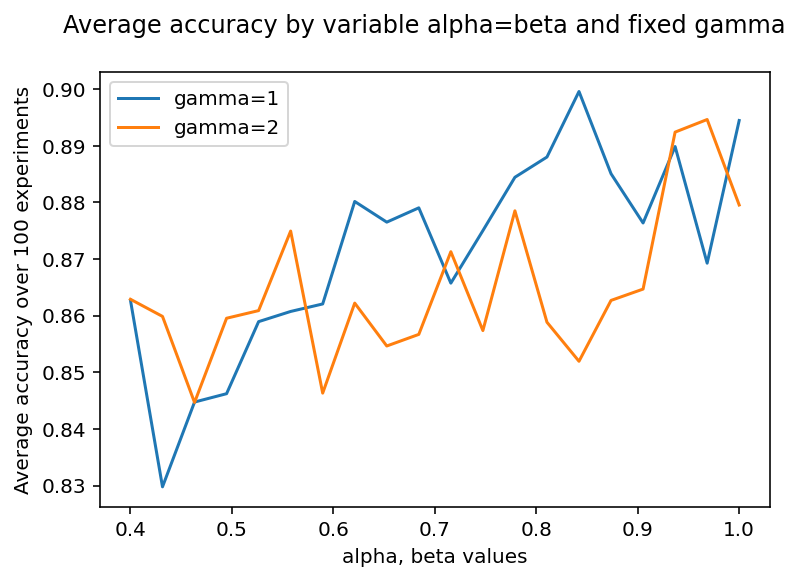

In [79]:
fig, ax = plt.subplots()
ax.plot(alphabeta_vec, res[1], label='gamma=1')
ax.plot(alphabeta_vec, res[2], label='gamma=2')
fig.suptitle('Average accuracy by variable alpha=beta and fixed gamma')
ax.set_xlabel('alpha, beta values')
ax.set_ylabel(f'Average accuracy over {task_2_3_2_n_repetitions} experiments') # , rotation='horizontal') # There are many parameters - we should explore the documantation to find what we seek
ax.legend();

Explain your results: 

🔵 **Answer**:

In 100 repetitions, we can see a much clearer trend of increasing accuracy as alpha and beta increase. As we mentioned in question 2.1, the alpha and beta parameters correspond to the diminishing effect of the utility. The smaller alpha and beta are, the further the choice deviates from the linear rational choice, which makes it harder for a linear regressor to predict.   


What can we conclude about the performance of a logistic regression classifier on behavioral data? What can explain the above observations?

🔵 **Answer**:

Although the rational choice can be modeled with logistic regression with rather good accuracy, when their behavior starts to deviate from rational, the harder it gets to predict. We might need a more complex hypothesis class to predict this nonlinear value perception. 

## Exercise 2.4: Exploratory Analysis (Open-Ended)

We present three open-ended questions. Please choose one of them and answer in detail. **Bonus will be given for solving more than one question**.

This task is exploratory, and we encourage you to try different and creative approaches to solve it. In your answers, you should design and run appropriate experiment(s) - state your hypotheses, show plots that support your claim, and explain them.

### Option 1: Alternative probability weighting

Up until now, the decision model we analyzed assumed $\pi$ to be neutral ($\pi(p)=p$). A model with the following $\pi$ is proposed:

$$\pi(p)=(1-p)\cdot\sqrt{p}+p\cdot(1-\sqrt{1-p})
$$

Will this change the accuracy analysis results? If so, how and in which direction? If not, why? Explain, and run experiments to support your claims.

### Option 2: Estimating behavioral deviations

Assuming neutral $\pi$ ($\pi(p)=p$) and a power S-shaped utility function $v$ (as described in Ex. 2.1), propose a way to estimate the functional parameters $\alpha,\beta,\gamma$ from data. Support your claims using simulated data.

### Option 3: Accounting for behavioral deviations

Assuming neutral $\pi$ ($\pi(p)=p$) and a power S-shaped utility function $v$ (as described in Ex. 2.1), significantly improve predictive performance compared to the naive logistic regression baseline. 

Support your claims using simulated data, and evaluate performance on behavioral models with parameters $\alpha, \beta, \gamma$ as defined in `prospect_params_lst` above.
Explain your methods. How did you train your model? Why?


🔵 **Answer**:

In [ ]:
## YOUR SOLUTION

Explain your results: 

🔵 **Answer**:

(YOUR SOLUTION)